In [1]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                    level=logging.INFO, stream=sys.stdout)

# import matplotlib as mpl
# mpl.use('pgf')  # Enable for pgf backend
from dsm_swap import rh_knitter, linear_decay, dag_decompose 
from dsm_swap import plot_circ

import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.converters import circuit_to_dag, dag_to_circuit
from functools import partial
%matplotlib inline

## DSM-SWAP Demo

In [2]:
# Configurations

seed = 38492314298

# Number of repetitions of the pattern of swaps (depends of topology).
swap_layers = 'log_2'

# The maximum number of layers considered on each step.
horizon = 2

# Number of restarts for the optimiser at each step.
restarts = 5

# Layout pass for emulating the transpilation process.
run_layout_pass = 1

dump_file = None

In [3]:
#  Prepare the input quantum circuit.
import gzip
from qiskit import qpy
with gzip.open('../stats/nannicini-qv8/qv256_batch1_original.qpy.gz', 'rb') as f:
    circuits_orig1 = qpy.load(f)
    qc = circuits_orig1[2]
    circuits_orig1 = None

In [4]:
# Other possible options for the input circuit.

# from qiskit.circuit.library import QuantumVolume
# qc = QuantumVolume(10).decompose()

# from qiskit.quantum_info import random_clifford
# qc = random_clifford(8, seed=1).to_circuit()

# MCX test. Use line connectivity
# from qiskit import QuantumCircuit
# horizon = 8
# qc = QuantumCircuit(5)
# qc.mcx(list(range(qc.num_qubits - 1)), qc.num_qubits - 1)
# qc = qc.decompose().decompose()

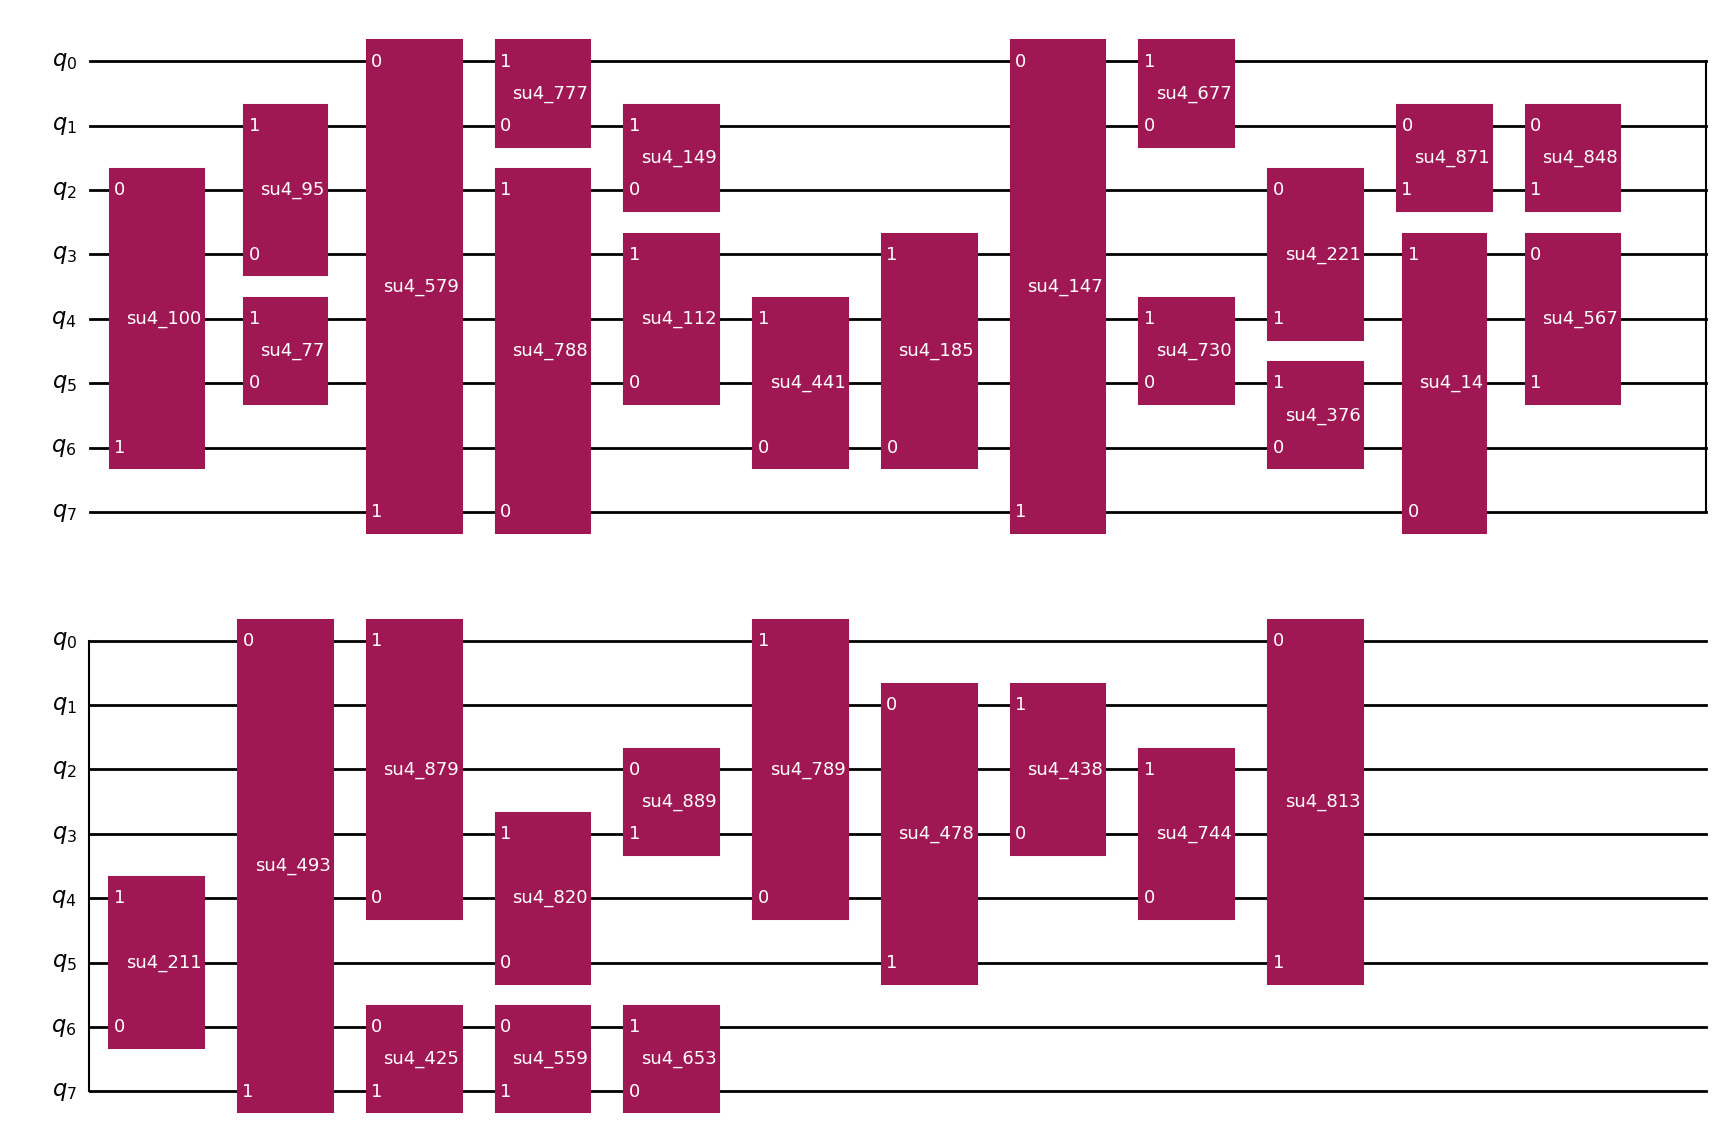

In [5]:
# Plot the input circuit.
qc.draw('mpl')

In [6]:
# Apply the layout pass.

from qiskit.transpiler.passes.layout.apply_layout import ApplyLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout

# cmap = CouplingMap.from_line(qc.num_qubits, bidirectional=True)
cmap = CouplingMap.from_ring(qc.num_qubits, bidirectional=True)
# cmap = CouplingMap.from_grid(5, 2)

layout = SabreLayout(cmap, max_iterations=3, seed=seed)
dag = circuit_to_dag(qc)
layout.run(dag)

apply_layout = ApplyLayout()
apply_layout.property_set['layout'] = layout.property_set['layout']
if run_layout_pass:
    dag = apply_layout.run(dag)

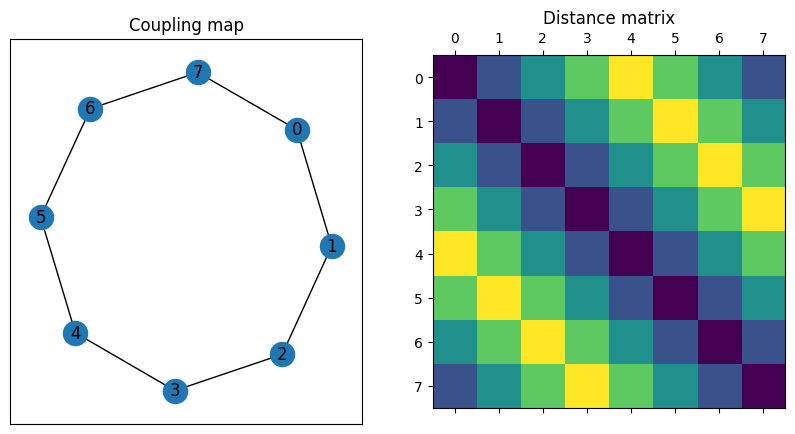

In [7]:
# Plot the coupling map and the corresponding distance matrix.

cmapg = nx.Graph()
cmapg.add_edges_from(cmap.get_edges())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
nx.draw_networkx(cmapg, ax=axs[0])
axs[0].set_title('Coupling map')
axs[1].matshow(cmap.distance_matrix)
axs[1].set_title('Distance matrix')
plt.show()

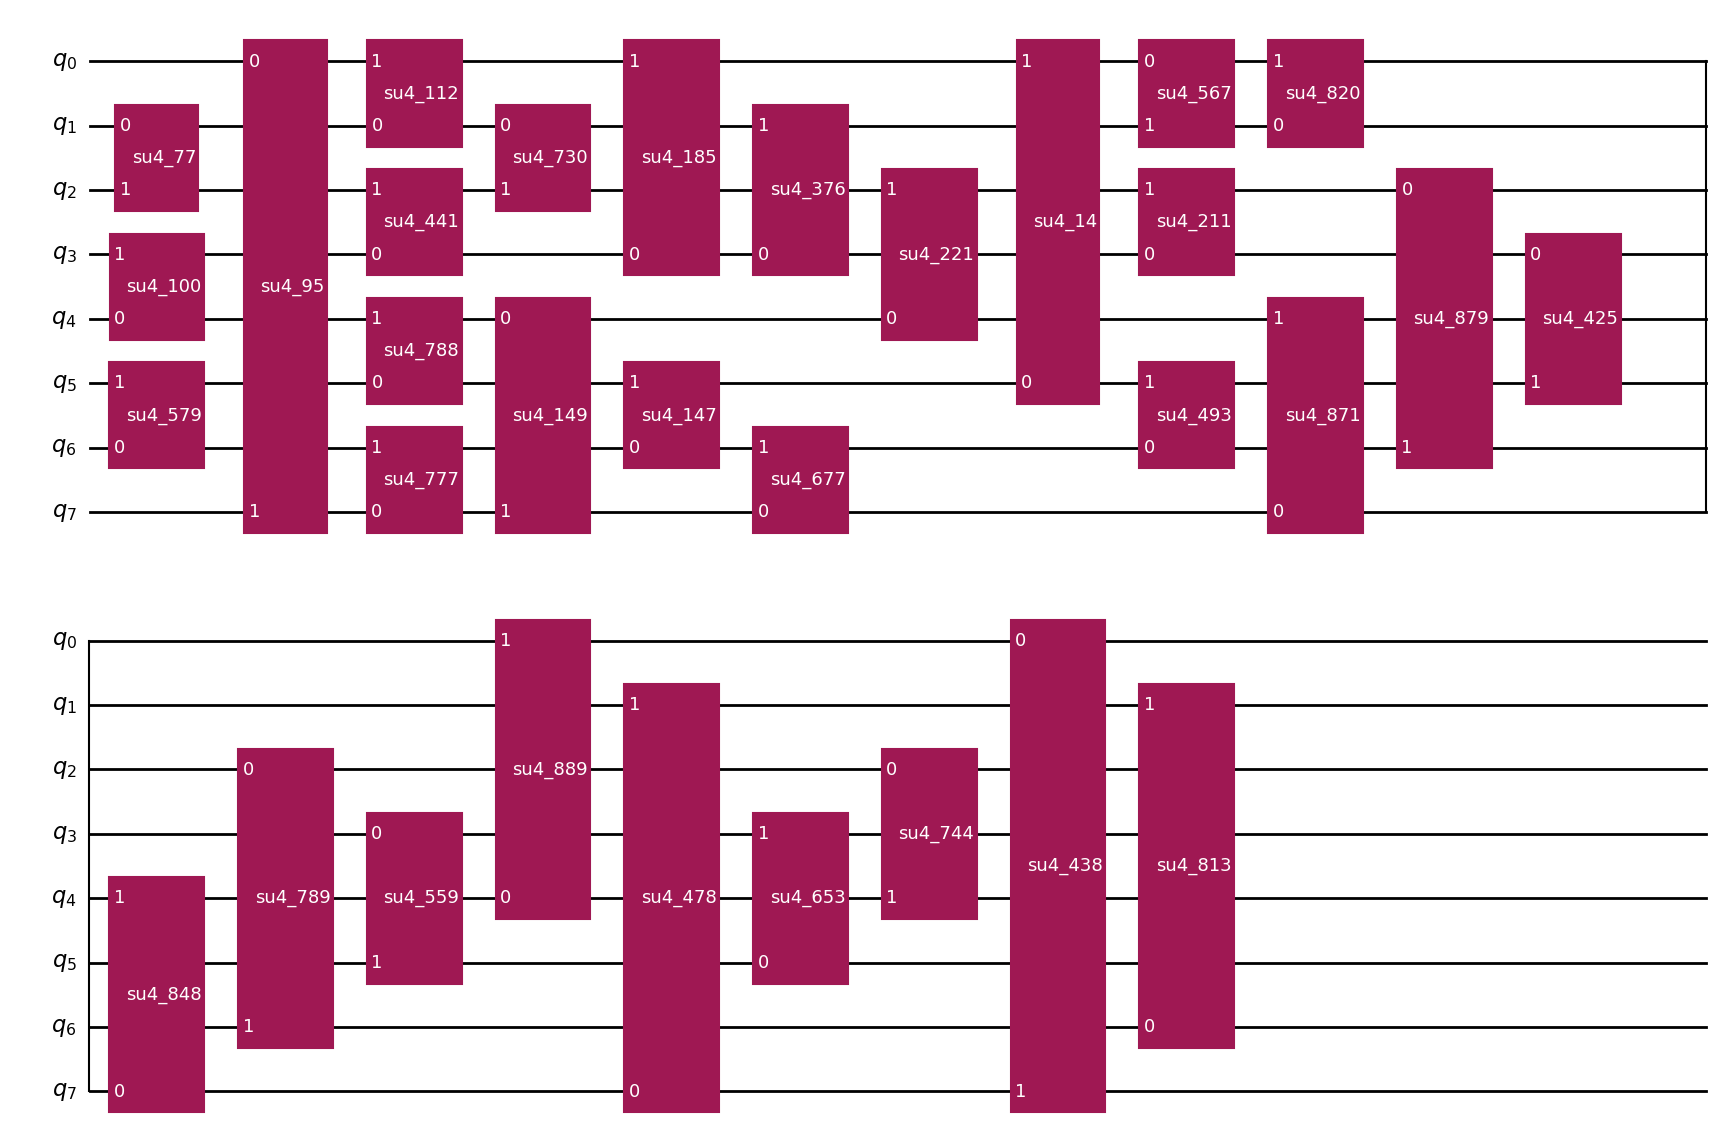

In [8]:
# Plot the input circuit after the layout pass.

dag_to_circuit(dag).draw('mpl')

In [9]:
# Run the DSM-SWAP algorithm.

dagd = dag_decompose(dag)   # Decompose the circuit into layers of commuting 2-qubit gates.
circ_adjs = dagd.get_adjs(mode='coo')   # Transform the layers into adjacency matrices.

# Run the Rolling Horizon Knitter.
layer_perms = rh_knitter(circ_adjs, max_optim_steps=30, seed=seed,
                         horizon=horizon,
                         restart=restarts,
                         cmap=cmap, hw_cost_decay=linear_decay,
                         swap_layers=swap_layers)

2024-03-15 13:17:30,673 | INFO : Loop restart, frame_start=0
2024-03-15 13:17:32,511 | INFO : Optim completed, hw_cost=0.00981579814106226, swap_cost=2.9232751330710016e-06
2024-03-15 13:17:32,556 | INFO : Knitter stats: {'param_count': 48, 'swap_layers': 3, 'optim_steps': 21}
2024-03-15 13:17:32,557 | INFO : Loop restart, frame_start=2


/Users/adekusar/home/projects/qc/dsm-swap/dsm_swap/swapmatic.py:144: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return reduce(torch.sparse.mm, m) if compose else list(m)


2024-03-15 13:17:34,184 | INFO : Optim completed, hw_cost=0.03695483133196831, swap_cost=4.72189998626709
2024-03-15 13:17:34,235 | INFO : Knitter stats: {'param_count': 48, 'swap_layers': 3, 'optim_steps': 25}
2024-03-15 13:17:35,808 | INFO : Optim completed, hw_cost=0.04173878952860832, swap_cost=4.704679012298584
2024-03-15 13:17:37,527 | INFO : Optim completed, hw_cost=0.03623542934656143, swap_cost=4.724599838256836
2024-03-15 13:17:39,423 | INFO : Optim completed, hw_cost=0.039962224662303925, swap_cost=4.71088171005249
2024-03-15 13:17:41,087 | INFO : Optim completed, hw_cost=0.040274620056152344, swap_cost=4.71056604385376
2024-03-15 13:17:41,136 | INFO : Loop restart, frame_start=4
2024-03-15 13:17:43,043 | INFO : Optim completed, hw_cost=0.06631667912006378, swap_cost=4.555066108703613
2024-03-15 13:17:43,082 | INFO : Knitter stats: {'param_count': 48, 'swap_layers': 3, 'optim_steps': 30}
2024-03-15 13:17:45,028 | INFO : Optim completed, hw_cost=0.05812188237905502, swap_cost

In [10]:
# Average layer density for the input circuit.
dagd.avg_layer_density()

1.0

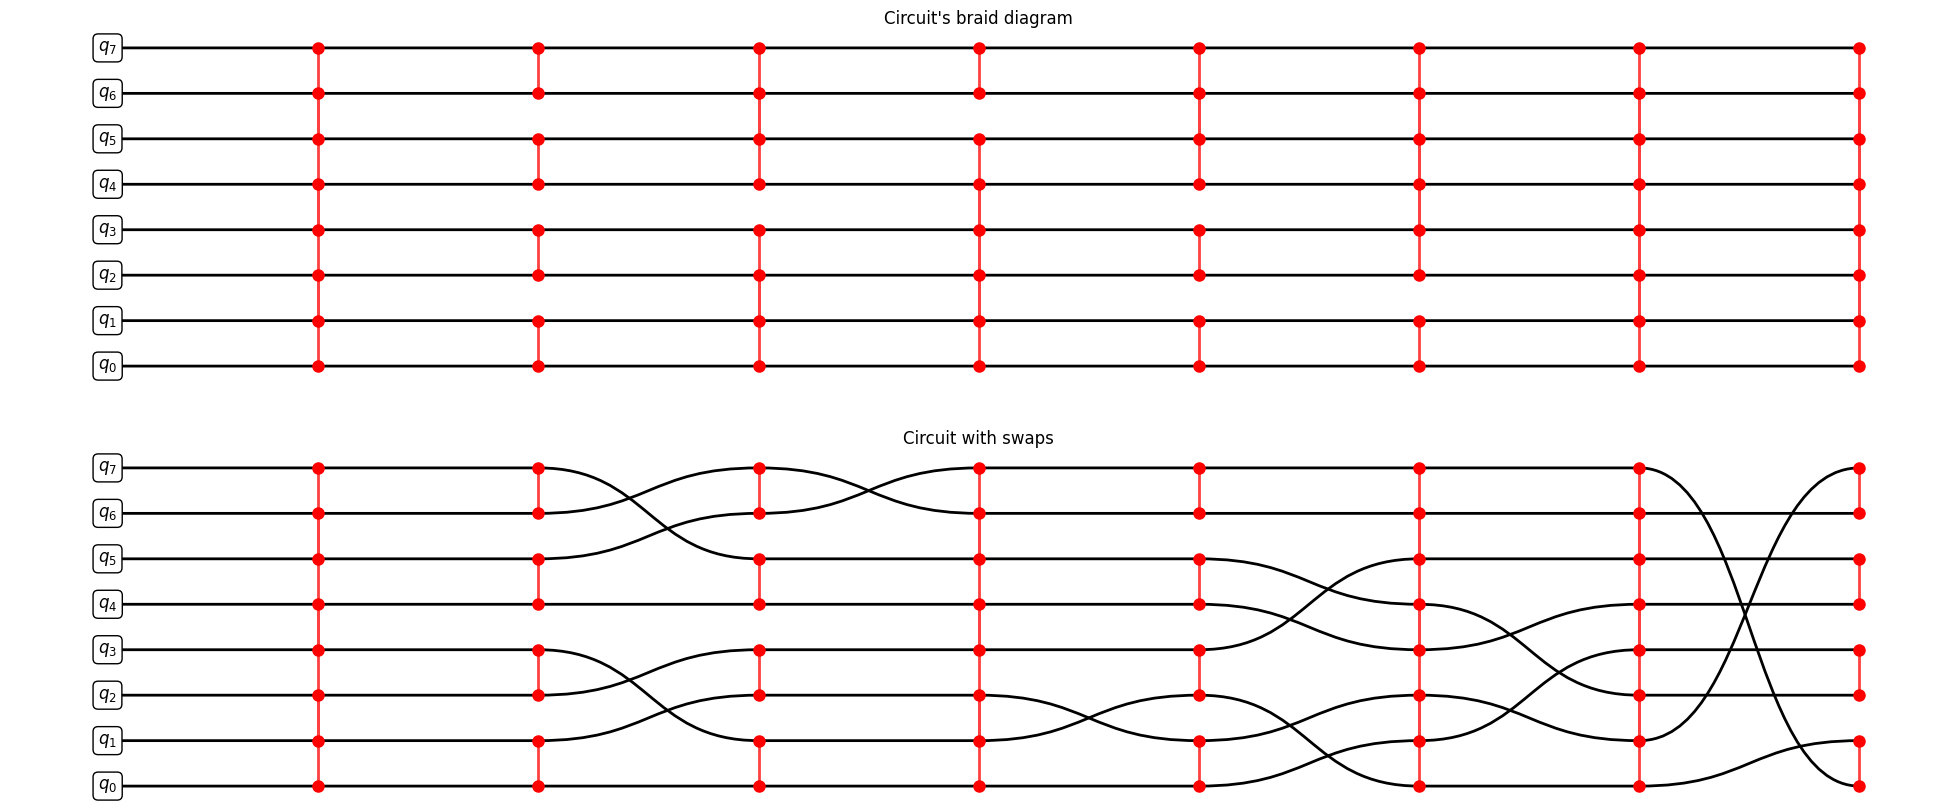

In [11]:
# Plot of the input (after layout pass) and the resulting circuit using the braid visualization.

fig, axs = plt.subplots(2, 1, figsize=(25, 10), facecolor='white')
from dsm_swap.math import reduce_level_np_matmul
layer_perms1 = reduce_level_np_matmul(layer_perms, 1)
plot_circ(perms=[np.eye(*p.shape) for p in layer_perms1], adjs_coo=circ_adjs, ax=axs[0])
plot_circ(perms=layer_perms1, adjs_coo=circ_adjs, ax=axs[1])
axs[0].set_title('Circuit\'s braid diagram')
axs[1].set_title('Circuit with swaps')
plt.show()
# plt.savefig('braid1.pgf', format='pgf')

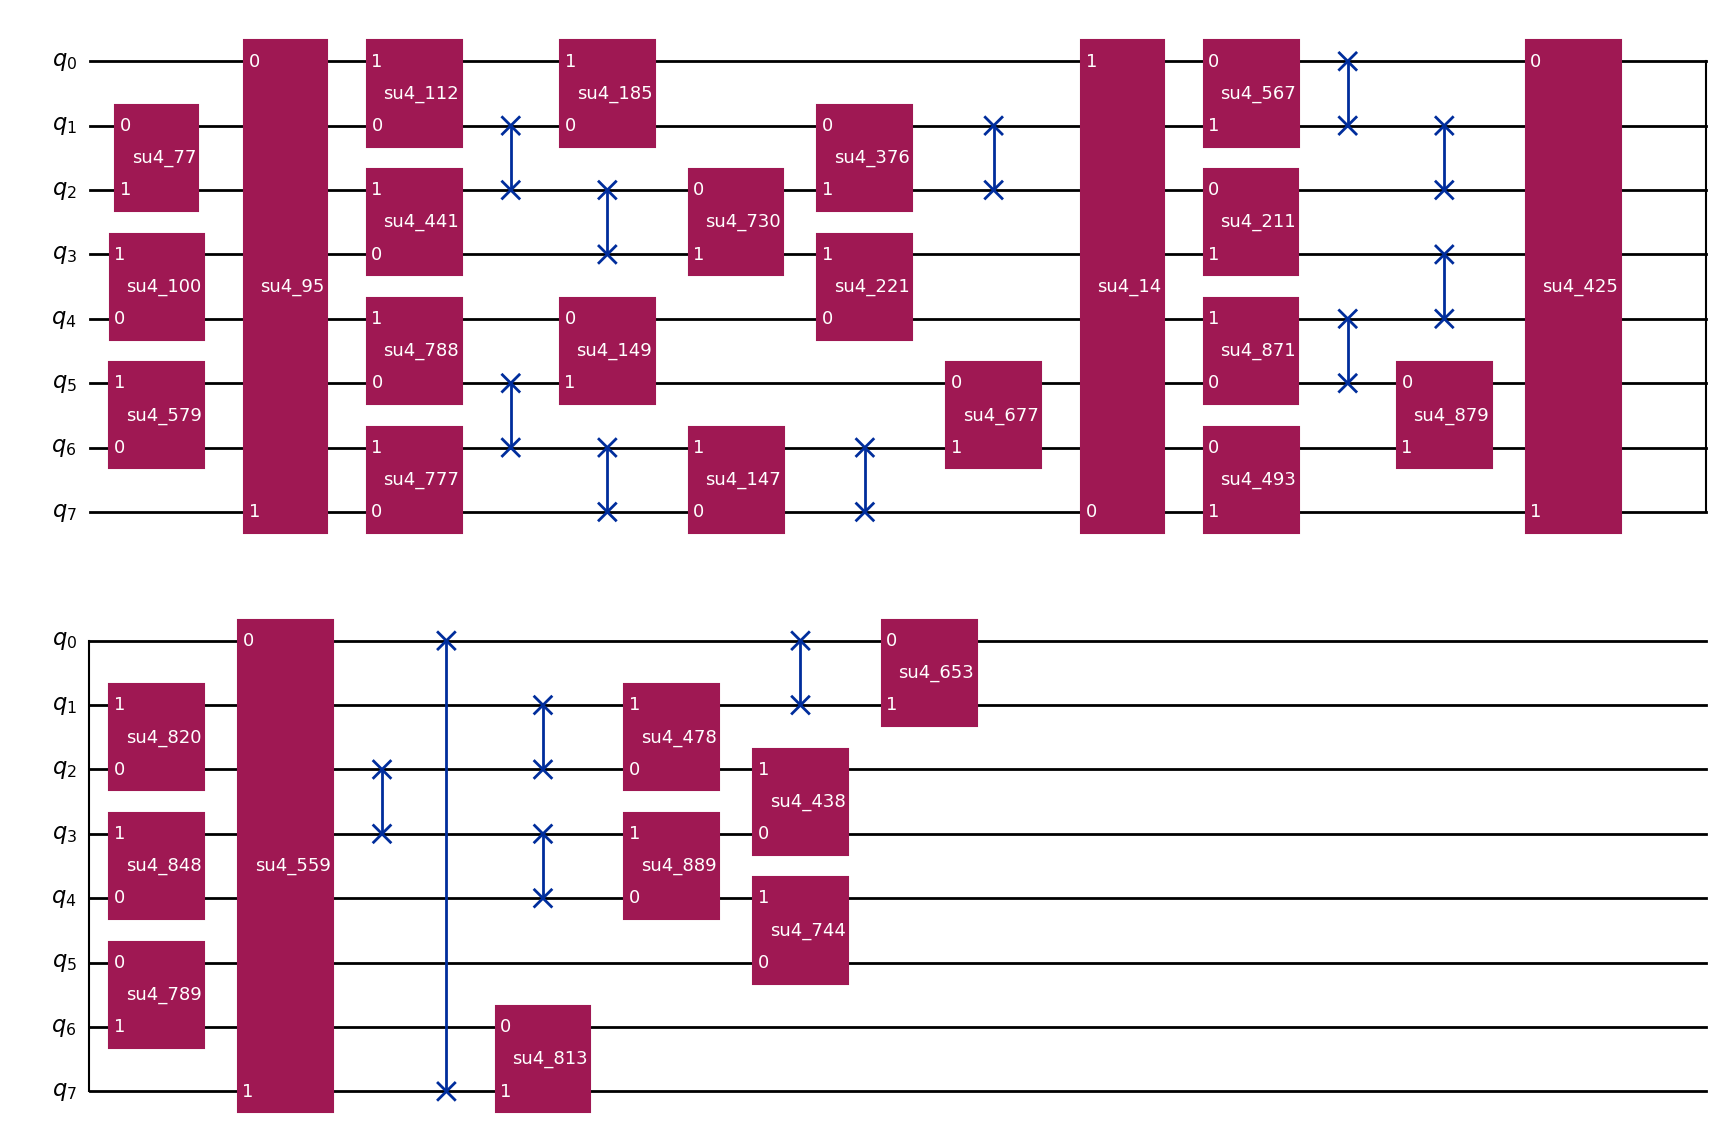

In [12]:
# *** Final circuit ***

qc3, final_layout = dagd.compose(layer_perms)
qc3 = dag_to_circuit(qc3)
qc3.draw('mpl')

In [13]:
# The final layout.

final_layout

Layout({
0: Qubit(QuantumRegister(8, 'q'), 3),
1: Qubit(QuantumRegister(8, 'q'), 7),
2: Qubit(QuantumRegister(8, 'q'), 5),
3: Qubit(QuantumRegister(8, 'q'), 1),
4: Qubit(QuantumRegister(8, 'q'), 4),
5: Qubit(QuantumRegister(8, 'q'), 0),
6: Qubit(QuantumRegister(8, 'q'), 6),
7: Qubit(QuantumRegister(8, 'q'), 2)
})

In [14]:
# Circuit statistics for DSM-SWAP after a compiling with level 3 optimization.

transpile(qc3, basis_gates=['u3', 'cx'], optimization_level=3).count_ops()

2024-03-15 13:18:01,618 | INFO : Pass: ContainsInstruction - 0.00572 (ms)
2024-03-15 13:18:01,619 | INFO : Pass: UnitarySynthesis - 0.07200 (ms)
2024-03-15 13:18:01,619 | INFO : Pass: HighLevelSynthesis - 0.05293 (ms)
2024-03-15 13:18:01,620 | INFO : Begin BasisTranslator from source basis set() to target basis {'cx', 'u3', 'delay', 'barrier', 'snapshot', 'measure', 'reset'}.
2024-03-15 13:18:01,620 | INFO : Basis translation path search completed in 0.000s.
2024-03-15 13:18:01,620 | INFO : Basis translation paths composed in 0.000s.
2024-03-15 13:18:01,621 | INFO : Basis translation instructions replaced in 0.000s.
2024-03-15 13:18:01,621 | INFO : Pass: BasisTranslator - 1.36709 (ms)
2024-03-15 13:18:01,621 | INFO : Pass: OptimizeSwapBeforeMeasure - 0.31996 (ms)
2024-03-15 13:18:01,622 | INFO : Pass: RemoveDiagonalGatesBeforeMeasure - 0.03910 (ms)
2024-03-15 13:18:01,622 | INFO : Pass: InverseCancellation - 0.08607 (ms)
2024-03-15 13:18:01,686 | INFO : Pass: UnitarySynthesis - 63.9331

OrderedDict([('u3', 194), ('cx', 99)])

In [15]:
dump_file = None

In [16]:
if dump_file is not None:
    with open(dump_file, 'wb') as fd:
        qpy.dump(qc3, fd)

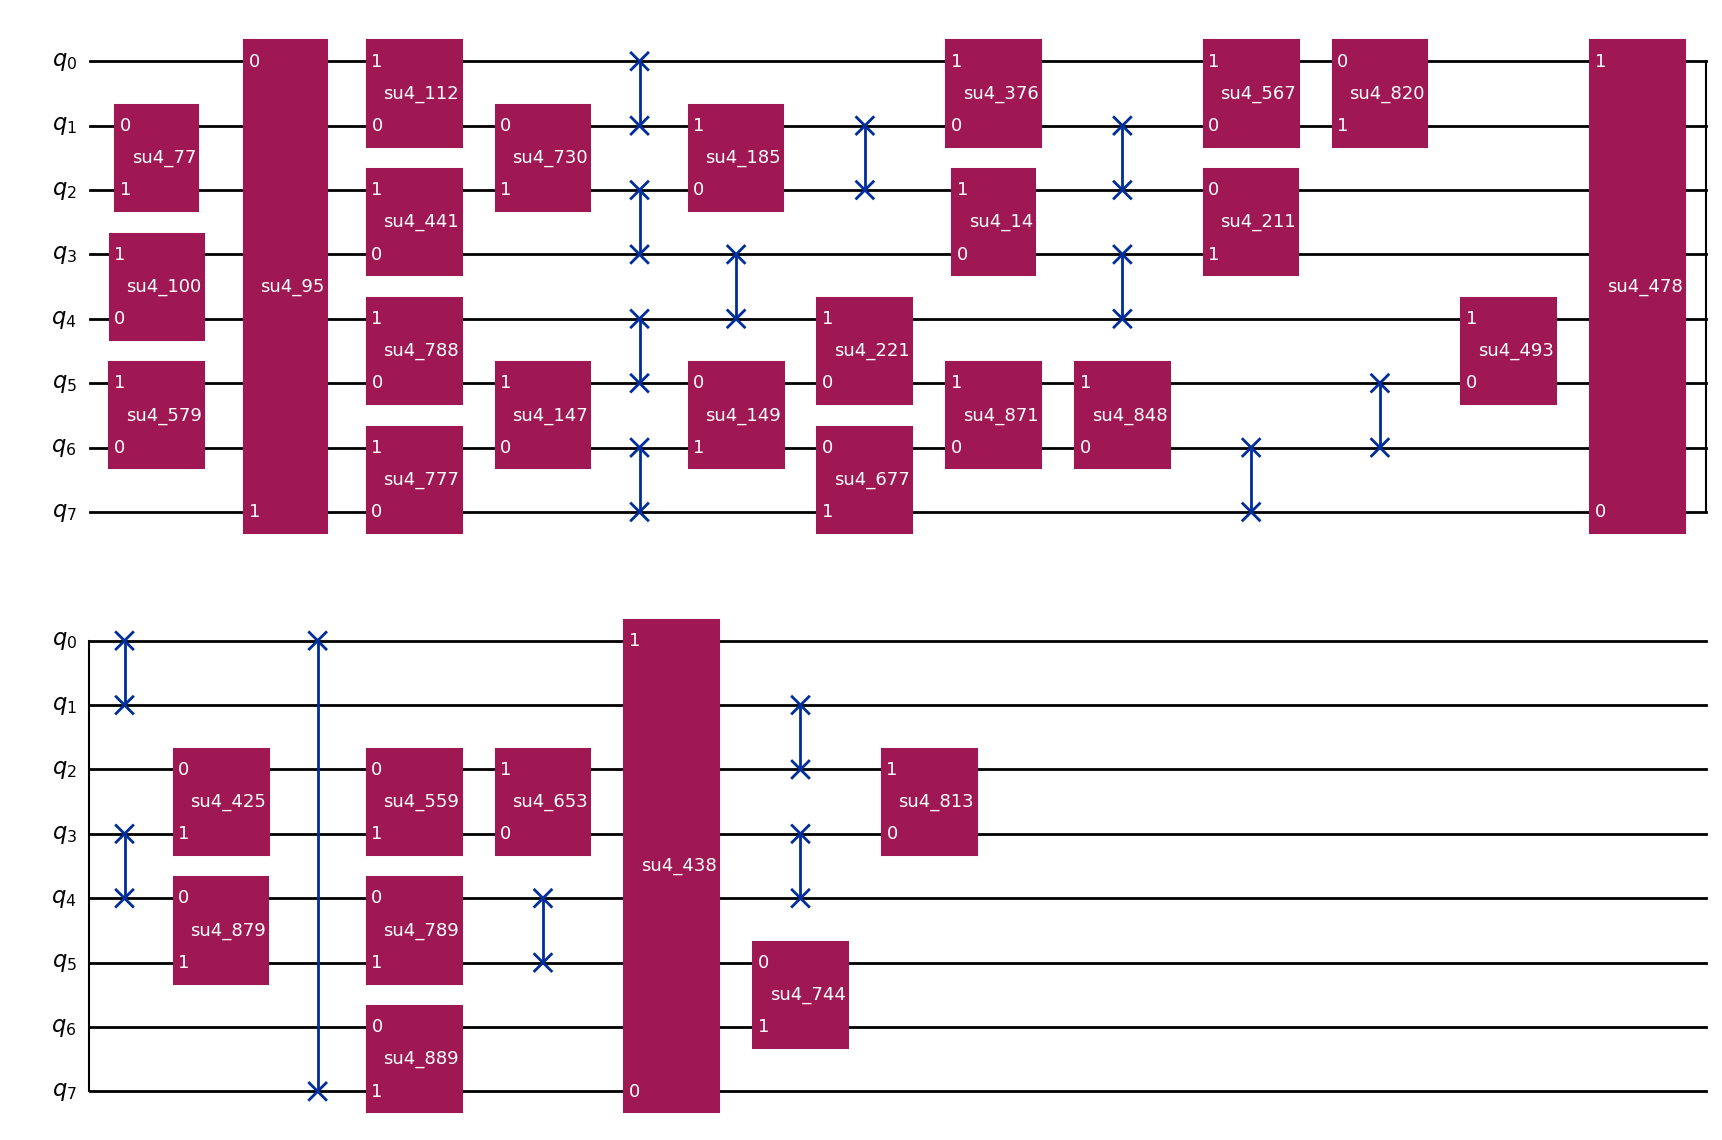

In [17]:
# *** SABRE Algorithm ***

def test_qiskit_swap(qc, swap_factory, cmap):
    dag = swap_factory(cmap).run(circuit_to_dag(qc))
    return dag_to_circuit(dag)

qc2 = test_qiskit_swap(dag_to_circuit(dag), partial(SabreSwap, heuristic='lookahead', seed=23894),
                       cmap=cmap)
qc2.draw('mpl')

In [18]:
# Circuit statistics for SABRE after a compiling with level 3 optimization.

transpile(qc2, basis_gates=['u3', 'cx'], optimization_level=3).count_ops()

2024-03-15 13:18:02,157 | INFO : Pass: ContainsInstruction - 0.00477 (ms)
2024-03-15 13:18:02,159 | INFO : Pass: UnitarySynthesis - 0.05889 (ms)
2024-03-15 13:18:02,159 | INFO : Pass: HighLevelSynthesis - 0.04506 (ms)
2024-03-15 13:18:02,160 | INFO : Begin BasisTranslator from source basis set() to target basis {'cx', 'u3', 'delay', 'barrier', 'snapshot', 'measure', 'reset'}.
2024-03-15 13:18:02,160 | INFO : Basis translation path search completed in 0.000s.
2024-03-15 13:18:02,160 | INFO : Basis translation paths composed in 0.000s.
2024-03-15 13:18:02,161 | INFO : Basis translation instructions replaced in 0.000s.
2024-03-15 13:18:02,161 | INFO : Pass: BasisTranslator - 1.30820 (ms)
2024-03-15 13:18:02,161 | INFO : Pass: OptimizeSwapBeforeMeasure - 0.29993 (ms)
2024-03-15 13:18:02,162 | INFO : Pass: RemoveDiagonalGatesBeforeMeasure - 0.03695 (ms)
2024-03-15 13:18:02,162 | INFO : Pass: InverseCancellation - 0.06104 (ms)
2024-03-15 13:18:02,289 | INFO : Pass: UnitarySynthesis - 126.487

OrderedDict([('u3', 191), ('cx', 123)])

In [19]:
import qiskit
qiskit.__version__

'1.0.2'